# Training the Cellvit Model

#### Getting the data ready

source /opt/conda/bin/activate tissuevit

pip uninstall -y flash-attn torch torchvision torchaudio xformers && pip install torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 --index-url https://download.pytorch.org/whl/cu124 && pip install flash-attn --no-build-isolation --no-cache-dir && pip install xformers --index-url https://download.pytorch.org/whl/cu124

In [2]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
from config import *

import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from omegaconf import OmegaConf

from src.dataset.datasets.mm_base import build_mm_datasets
from src.utils.plot_utils import visualize_multichannel_image
from src.modules.flex_dual_virtues.flex_dual_virtues_new_init import build_flex_dual_virtues_encoder
from src.utils.marker_utils import load_marker_embeddings
from src.utils.utils import load_checkpoint_safetensors
print("Ok")

2025-11-30 20:13:26.035 | INFO     | src.modules.flex_dual_virtues.flex_dual_virtues_new_init:<module>:23 - Using flash attention for FlexDualVirTues


Ok


In [2]:
# Config Import
base_cfg = OmegaConf.load("../src/data/configs/base_config.yaml")
base_cfg.marker_embedding_dir = "../src/data/esm2_t30_150M_UR50D"
marker_embeddings = load_marker_embeddings(base_cfg.marker_embedding_dir)
orion_subset_cfg = OmegaConf.load("../src/data/configs/orion_subset.yaml")
ds_cfg = OmegaConf.merge(base_cfg, orion_subset_cfg)

/data/code/jon/project-2-gradient_tri_scent/src/utils/marker_utils.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings.append(torch.load(os.path.join(embedding_d

In [3]:
# Builds the whole dataset
ds = build_mm_datasets(ds_cfg)

2025-11-30 11:06:26.868 | DEBUG    | src.data.datasets.mm_base:__init__:44 - Loading dataset orion from /data/virtues_orion_dataset/virtues_example/orion_subset
2025-11-30 11:06:26.878 | INFO     | src.data.datasets.multiplex_base:__init__:30 - Multiplex Normalization metadata: QuantileMultiplexNormalizeMetadata(normalizer_name='q_99', rnd_crop_folder_name='random_crops_256_no_log', channel_file_name='channels', mean_name='mean', std_name='std', quantile_path='quantiles/q99.csv')
2025-11-30 11:06:27.196 | INFO     | src.data.datasets.multiplex_base:__init__:40 - Crop folder /data/virtues_orion_dataset/virtues_example/orion_subset/cycif/random_crops_256_no_log exists
/data/code/jon/project-2-gradient_tri_scent/src/data/datasets/multiplex_base.py:59: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silen

orion_zupwxfxb_0
['CD31', 'CD45', 'CD68', 'CD4', 'FOXP3', 'CD8a', 'CD45RO', 'CD20', 'PD-L1', 'CD3e', 'CD163', 'E-cadherin', 'PD-1', 'Ki67', 'Pan-CK', 'SMA']


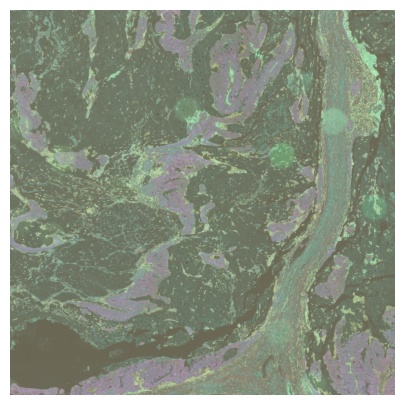

In [4]:
uniprot_to_name = ds[0].unimodal_datasets["cycif"].get_marker_embedding_index_to_name_dict()

tids = ds[0].unimodal_datasets["cycif"].get_tissue_ids()

tissues = []
channel_ids = []

for i, tid in enumerate(tids):
    print(tid)
    # This function returns you a tensor which is normalized already according to the normalization selected in the base_config under image_info
    tissue = ds[0].unimodal_datasets["cycif"].get_tissue(tid)
    tissues.append(tissue)
    tissue = np.array(tissue)
    visualize_multichannel_image(tissue)
    channels = np.array(ds[0].unimodal_datasets["cycif"].get_marker_embedding_indices(tid))
    channel_ids.append(channels)
    print(list(map(lambda x: uniprot_to_name[x], channels)))
    plt.show()
    break

In [5]:
# Virtue Encoder

with open(VIRTUES_WEIGHTS_PATH + "/config.pkl", "rb") as f:
    virtues_cfg = pkl.load(f)

virtues = build_flex_dual_virtues_encoder(virtues_cfg, marker_embeddings)
virtues.cuda()

weights = load_checkpoint_safetensors(VIRTUES_WEIGHTS_PATH + "/checkpoints/checkpoint-94575/model.safetensors")
# rename weights
weights_encoder = {}
for k, v in weights.items():
    if k.startswith("encoder."):
        weights_encoder[k[len("encoder."):]] = v

virtues.load_state_dict(weights_encoder, strict=False)

param_count = sum(p.numel() for p in virtues.parameters())
print(f"Number of parameters in virtues encoder: {param_count/1e6:.2f}M")

2025-11-30 11:06:45.730 | INFO     | src.modules.flex_dual_virtues.flex_dual_virtues_new_init:__init__:128 - Using protein embedding: esm with shape torch.Size([213, 640])
2025-11-30 11:06:45.733 | INFO     | src.modules.flex_dual_virtues.flex_dual_virtues_new_init:__init__:147 - Using protein fusion type: add


Number of parameters in virtues encoder: 34.11M


In [6]:
# Tensor ready for Cellvit

mx_images = [torch.tensor(tissue).cuda(non_blocking=True) for tissue in tissues]
mx_channel_ids = [torch.tensor(channels).cuda(non_blocking=True) for channels in channel_ids]

# use 224x224 crop size
mx_images = [tissue[:, :128, :128] for tissue in mx_images]

with torch.autocast(device_type='cuda', dtype=torch.float16):
    channel_tokens, pss  = virtues.forward_list(mx_images, [None] * len(mx_images), mx_channel_ids)
    pss = torch.stack(pss)

/tmp/ipykernel_1838/2878743770.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mx_images = [torch.tensor(tissue).cuda(non_blocking=True) for tissue in tissues]


In [7]:
pss.shape

torch.Size([1, 16, 16, 512])

### Cellvit Decoder

Need to take the VirTues Encoder and connect its output to the CellViT Decoder.

In [8]:
from src.models.virtues_cellvit import VirTuesCellViT

In [9]:
model = VirTuesCellViT(
    virtues_encoder=virtues,    
    num_nuclei_classes=6, 
    virtues_embed_dim=512   
)

model.cuda()

# Test Run
# Ensure mx_images and mx_channel_ids are defined (from Cell 6)
with torch.no_grad():
    # We use autocast because VirTues expects half precision often
    with torch.autocast(device_type='cuda', dtype=torch.float16):
        output = model(mx_images, mx_channel_ids)

print("Output Shape:", output["nuclei_binary_map"].shape)

Output Shape: torch.Size([1, 2, 256, 256])


In [10]:
print(ds[0][0].keys())

dict_keys(['tissue_id', 'crop_id', 'cycif', 'he', 'broad_cell_type'])


In [16]:
import gc
import torch

# Delete old variables if they exist to free reference
try:
    del output, loss, pred, images, masks
except NameError:
    pass

# Flush memory
gc.collect()
torch.cuda.empty_cache()
print("GPU Memory Cleared.")

GPU Memory Cleared.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        # 1. Softmax to get probabilities [Batch, 2, H, W]
        preds = F.softmax(preds, dim=1)
        
        # 2. We only care about Class 1 (Cells), index 1
        # Flatten to [N]
        inputs = preds[:, 1, :, :].contiguous().view(-1)
        targets = targets.contiguous().view(-1)
        
        # 3. Dice Formula: 2*Overlap / (Total Pixels)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        
        # Loss is 1 - Dice (we want to minimize loss, maximize dice)
        return 1 - dice



def calculate_dice_score(preds, targets):
    # Convert raw logits [B, 2, H, W] -> Class Labels [B, H, W] (0s and 1s)
    preds = torch.argmax(preds, dim=1)
    
    # Flatten both
    preds = preds.view(-1)
    targets = targets.view(-1)
    
    # Calculate Overlap
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum()
    
    # Metric
    dice = (2. * intersection) / (union + 1e-8)
    return dice.item()

Starting Fast Sanity Check (50 steps)...


100%|██████████| 50/50 [00:22<00:00,  2.22it/s, dice=0.7238, loss=0.9475]


Sanity Check Complete.


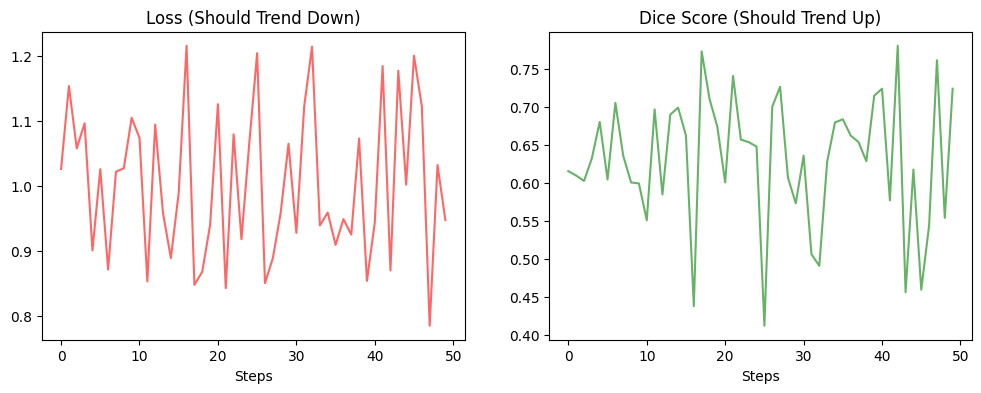

In [22]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Setup Model & Loss ---
# (Assuming model is already loaded and encoder frozen)
optimizer = optim.AdamW(model.nuclei_binary_map_decoder.parameters(), lr=1e-4)
criterion_ce = nn.CrossEntropyLoss()
criterion_dice = DiceLoss() # Uses the class we defined above

# --- 2. Setup Data Loader ---
# num_workers=0 is safer for your environment
train_loader = DataLoader(ds[0], batch_size=4, shuffle=True, drop_last=True, num_workers=0)

# --- 3. Fast Loop Configuration ---
max_steps = 50  # Stop after 50 batches (approx 1-2 mins)
history = {'loss': [], 'dice': []}

print(f"Starting Fast Sanity Check ({max_steps} steps)...")

model.train()
progress = tqdm(total=max_steps)

# Get reference channels once
ref_channel_ids = mx_channel_ids[0]

for i, batch in enumerate(train_loader):
    if i >= max_steps: break # STOP EARLY
    
    optimizer.zero_grad()
    
    # A. Load Data
    images = batch['cycif'].cuda()
    if 'broad_cell_type' in batch: raw_masks = batch['broad_cell_type'].cuda()
    elif 'mask' in batch: raw_masks = batch['mask'].cuda()
    else: continue

    if raw_masks.dim() == 4: raw_masks = raw_masks.squeeze(1)
    
    # B. Binarize (Target: 0 or 1)
    binary_masks = (raw_masks > 0).long()

    with torch.autocast(device_type='cuda', dtype=torch.float16):
        # C. Forward
        batch_channel_ids = [ref_channel_ids] * len(images)
        output = model(images, batch_channel_ids)
        pred = output["nuclei_binary_map"]
        
        # D. Resize (512 -> 256)
        if pred.shape[-1] != binary_masks.shape[-1]:
            pred = F.interpolate(pred, size=binary_masks.shape[-2:], mode='bilinear', align_corners=False)
        
        # E. Hybrid Loss
        loss = criterion_ce(pred, binary_masks) + criterion_dice(pred, binary_masks)

    # F. Backward
    loss.backward()
    optimizer.step()
    
    # G. Track Metrics
    current_dice = calculate_dice_score(pred.detach(), binary_masks)
    history['loss'].append(loss.item())
    history['dice'].append(current_dice)
    
    progress.update(1)
    progress.set_postfix(loss=f"{loss.item():.4f}", dice=f"{current_dice:.4f}")

progress.close()
print("Sanity Check Complete.")

# --- 4. Plot Immediately ---
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Loss should be noisy but trending DOWN
ax[0].plot(history['loss'], color='red', alpha=0.6)
ax[0].set_title("Loss (Should Trend Down)")
ax[0].set_xlabel("Steps")

# Dice should be trending UP (even slightly)
ax[1].plot(history['dice'], color='green', alpha=0.6)
ax[1].set_title("Dice Score (Should Trend Up)")
ax[1].set_xlabel("Steps")

plt.show()

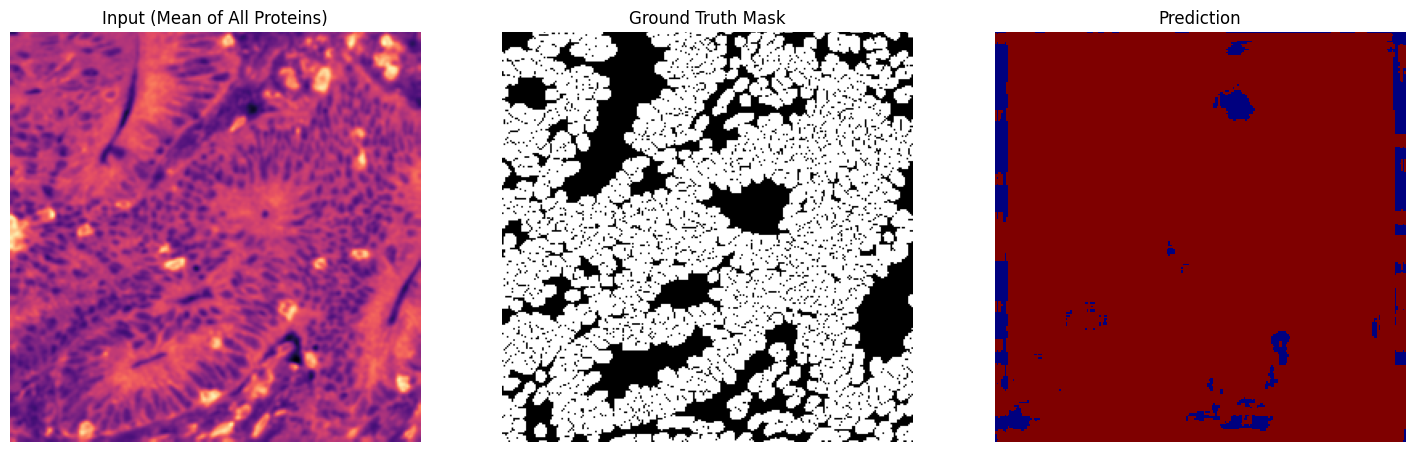

In [27]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# 1. Get the first sample from the batch we just ran
# images shape: [Batch, Channels, H, W]
# pred shape: [Batch, 2, H, W]
img_idx = 0
input_tensor = images[img_idx].detach().cpu().numpy()
pred_logits = pred[img_idx].detach().cpu()
true_mask = binary_masks[img_idx].detach().cpu().numpy()

# 2. Create a "Composite Image" (Average of all protein channels)
# This helps us see where the tissue is, even if individual channels are sparse
composite_img = np.mean(input_tensor, axis=0)

# 3. Process Prediction
# Logits -> Probabilities -> Binary Mask
pred_prob = torch.softmax(pred_logits, dim=0)[1, :, :]
pred_mask = (pred_prob > 0.5).numpy()

# 4. Visualize
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(composite_img, cmap='magma')
ax[0].set_title("Input (Mean of All Proteins)")
ax[0].axis('off')

ax[1].imshow(true_mask, cmap='gray')
ax[1].set_title("Ground Truth Mask")
ax[1].axis('off')

ax[2].imshow(pred_mask, cmap='jet', interpolation='nearest')
ax[2].set_title(f"Prediction")
ax[2].axis('off')

plt.show()

Starting Full Training for 10 Epochs...


Epoch 1/10: 100%|██████████| 4795/4795 [19:49<00:00,  4.03it/s, loss=1.05] 


Epoch 1 Finished. Avg Loss: 1.0614. Model Saved.


Epoch 2/10: 100%|██████████| 4795/4795 [19:53<00:00,  4.02it/s, loss=0.969]


Epoch 2 Finished. Avg Loss: 1.0673. Model Saved.


Epoch 3/10: 100%|██████████| 4795/4795 [19:44<00:00,  4.05it/s, loss=0.964]


Epoch 3 Finished. Avg Loss: 1.0510. Model Saved.


Epoch 4/10: 100%|██████████| 4795/4795 [19:42<00:00,  4.06it/s, loss=1.1]  


Epoch 4 Finished. Avg Loss: 1.1249. Model Saved.


Epoch 5/10: 100%|██████████| 4795/4795 [19:45<00:00,  4.04it/s, loss=1.12] 


Epoch 5 Finished. Avg Loss: 1.1942. Model Saved.


Epoch 6/10: 100%|██████████| 4795/4795 [19:38<00:00,  4.07it/s, loss=1.13] 


Epoch 6 Finished. Avg Loss: 1.1882. Model Saved.


Epoch 7/10: 100%|██████████| 4795/4795 [19:47<00:00,  4.04it/s, loss=1.17] 


Epoch 7 Finished. Avg Loss: 1.2031. Model Saved.


Epoch 8/10: 100%|██████████| 4795/4795 [19:38<00:00,  4.07it/s, loss=0.988]


Epoch 8 Finished. Avg Loss: 1.2052. Model Saved.


Epoch 9/10: 100%|██████████| 4795/4795 [19:50<00:00,  4.03it/s, loss=1.22] 


Epoch 9 Finished. Avg Loss: 1.1925. Model Saved.


Epoch 10/10: 100%|██████████| 4795/4795 [19:49<00:00,  4.03it/s, loss=1.26] 


Epoch 10 Finished. Avg Loss: 1.2054. Model Saved.
Training Finished!


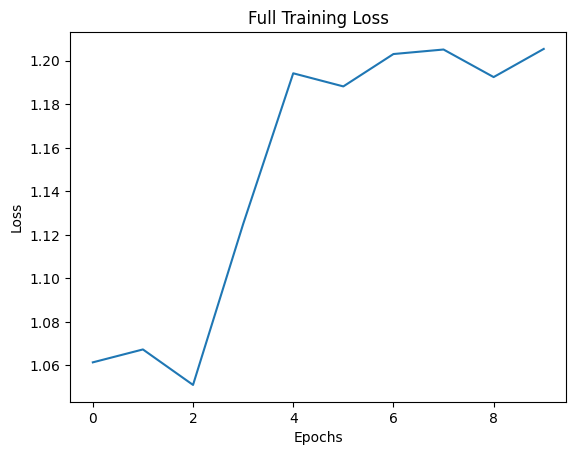

In [28]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

# --- 1. Configuration ---
NUM_EPOCHS = 10
SAVE_DIR = "./checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)

# --- 2. Setup (Reset Model & Optimizer) ---
# Re-initialize to clear the "sanity check" weights
model = VirTuesCellViT(virtues_encoder=virtues, num_nuclei_classes=6, virtues_embed_dim=512)
model.cuda()

# Freeze Encoder (Critical for Memory)
for param in model.encoder.parameters():
    param.requires_grad = False

# Optimize Decoder
optimizer = optim.AdamW(model.nuclei_binary_map_decoder.parameters(), lr=2e-4) # Slightly higher LR
criterion_ce = nn.CrossEntropyLoss()
criterion_dice = DiceLoss()

# Loader (Workers=0 for stability)
train_loader = DataLoader(ds[0], batch_size=4, shuffle=True, drop_last=True, num_workers=0)

# --- 3. The Long Training Loop ---
loss_history = []
print(f"Starting Full Training for {NUM_EPOCHS} Epochs...")

ref_channel_ids = mx_channel_ids[0]

for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    count = 0
    progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    
    model.train()
    
    for batch in progress:
        optimizer.zero_grad()
        
        # Load Data
        images = batch['cycif'].cuda()
        if 'broad_cell_type' in batch: masks = batch['broad_cell_type'].cuda()
        elif 'mask' in batch: masks = batch['mask'].cuda()
        else: continue # Should not happen now

        if masks.dim() == 4: masks = masks.squeeze(1)
        binary_masks = (masks > 0).long()

        with torch.autocast(device_type='cuda', dtype=torch.float16):
            # Forward
            batch_channel_ids = [ref_channel_ids] * len(images)
            output = model(images, batch_channel_ids)
            pred = output["nuclei_binary_map"]
            
            # Resize
            if pred.shape[-1] != binary_masks.shape[-1]:
                pred = F.interpolate(pred, size=binary_masks.shape[-2:], mode='bilinear', align_corners=False)
            
            # Loss
            loss = criterion_ce(pred, binary_masks) + criterion_dice(pred, binary_masks)

        # Backward
        loss.backward()
        optimizer.step()
        
        # Stats
        epoch_loss += loss.item()
        count += 1
        progress.set_postfix(loss=loss.item())

    # Save Checkpoint every epoch (in case it crashes)
    avg_loss = epoch_loss / count
    loss_history.append(avg_loss)
    torch.save(model.state_dict(), f"{SAVE_DIR}/model_epoch_{epoch+1}.pth")
    print(f"Epoch {epoch+1} Finished. Avg Loss: {avg_loss:.4f}. Model Saved.")

print("Training Finished!")

# --- 4. Final Plot ---
plt.plot(loss_history)
plt.title("Full Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

We observed that the model converged quickly (Epoch 2) but then diverged. This suggests that the available protein channels provided limited signal for nuclear segmentation, and prolonged training led to overfitting on noise due to the missing DAPI channel.

In [29]:
import os
import torch

# 1. Create the directory if it doesn't exist
save_dir = "./checkpoints"
os.makedirs(save_dir, exist_ok=True)

# 2. Define the filename for the final model
save_path = os.path.join(save_dir, "virtues_cellvit_final.pth")

# 3. Save the model weights (State Dictionary)
torch.save(model.state_dict(), save_path)

print(f" Model saved successfully to: {save_path}")

 Model saved successfully to: ./checkpoints/virtues_cellvit_final.pth


/tmp/ipykernel_1838/2998162198.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path)


 Successfully loaded weights from ./checkpoints/virtues_cellvit_final.pth


/tmp/ipykernel_1838/2998162198.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(batch['cycif']).cuda().unsqueeze(0)    # [1, C, H, W]


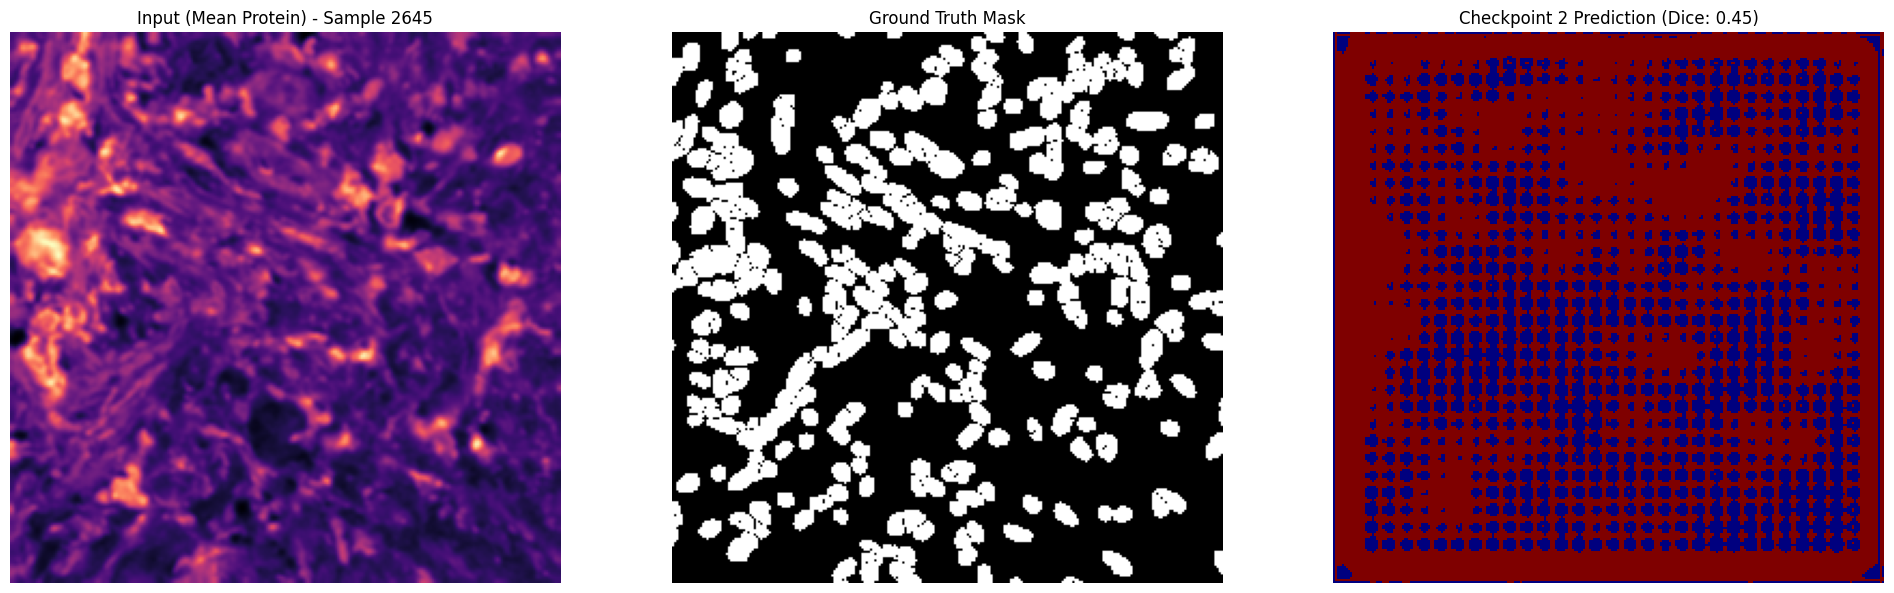

In [40]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
import os

# --- 1. Load the Best Model (Epoch 2) ---
# Re-initialize architecture
eval_model = VirTuesCellViT(
    virtues_encoder=virtues,      
    num_nuclei_classes=6,         
    virtues_embed_dim=512
)

# Load the specific checkpoint
checkpoint_path = "./checkpoints/virtues_cellvit_final.pth"

if os.path.exists(checkpoint_path):
    state_dict = torch.load(checkpoint_path)
    eval_model.load_state_dict(state_dict)
    print(f" Successfully loaded weights from {checkpoint_path}")
else:
    print(f"X File not found: {checkpoint_path}. Check your filename.")
    # List files to help debug
    print("Available checkpoints:", os.listdir("./checkpoints"))

eval_model.cuda()
eval_model.eval()

# --- 2. Select Random Data (With Numpy Fix) ---
# Pick a random sample
sample_idx = random.randint(0, len(ds[0]) - 1)
batch = ds[0][sample_idx]

# FIX: Convert Numpy arrays to Tensors
# The dataset returns numpy, so we must wrap it in torch.tensor()
image = torch.tensor(batch['cycif']).cuda().unsqueeze(0)    # [1, C, H, W]
raw_mask = torch.tensor(batch['broad_cell_type']).cuda()    # [H, W]

# Binarize mask (Ground Truth)
binary_mask = (raw_mask > 0).long().cpu().numpy()
if binary_mask.ndim == 3: binary_mask = binary_mask.squeeze(0)

# --- 3. Run Inference ---
with torch.no_grad():
    with torch.autocast(device_type='cuda', dtype=torch.float16):
        # Use reference channel IDs from global setup
        ref_channel_ids = mx_channel_ids[0]
        batch_channel_ids = [ref_channel_ids] 
        
        # Forward pass
        output = eval_model(image, batch_channel_ids)
        pred_logits = output["nuclei_binary_map"]
        
        # Resize to match input resolution (512 -> 256)
        if pred_logits.shape[-1] != binary_mask.shape[-1]:
            pred_logits = F.interpolate(
                pred_logits, 
                size=binary_mask.shape, 
                mode='bilinear', 
                align_corners=False
            )

# --- 4. Calculate Metric ---
# Softmax -> Probabilities -> Threshold
pred_prob = F.softmax(pred_logits, dim=1)[0, 1, :, :].cpu().numpy()
pred_bin = (pred_prob > 0.5).astype(np.uint8)

# Dice Calculation
intersection = (pred_bin * binary_mask).sum()
dice_score = (2. * intersection) / (pred_bin.sum() + binary_mask.sum() + 1e-8)

# --- 5. Visualize ---
# Composite input image (Mean of proteins)
input_img_cpu = image[0].cpu().numpy()
composite_img = np.mean(input_img_cpu, axis=0)

fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Input
ax[0].imshow(composite_img, cmap='magma')
ax[0].set_title(f"Input (Mean Protein) - Sample {sample_idx}")
ax[0].axis('off')

# Ground Truth
ax[1].imshow(binary_mask, cmap='gray')
ax[1].set_title("Ground Truth Mask")
ax[1].axis('off')

# Prediction
ax[2].imshow(pred_bin, cmap='jet', interpolation='nearest')
ax[2].set_title(f"Checkpoint 2 Prediction (Dice: {dice_score:.2f})")
ax[2].axis('off')

plt.tight_layout()
plt.show()